# Analysing the Base GD data available for the CNFL service territory

At `data/Base_GD.csv`, we have a Comma-Separated Values file containing the electric utility bills for customers in the country of Costa Rica, from January 2017 until October of 2018. From this file, which indicates the amount of electricity each customer generated on their own, we can infer the capacity of photovoltaic (PV) system they have installed.

At the same time, we have an analytical estimate of what solar panel capacity is the ideal for customers of different electricity usage levels to install. This estimate is based on predicted load curves for different classes of consumers.

We wish to evaluate the performance of our analytical model of ideal PV adoption in comparison with the reality of PV adoption on the ground in Costa Rica. This notebook presents this data in graphical form, breaking down the data into several subgroups to highlight performance in the different sectors of the electricity market.

This notebook focused on the CNFL electric utility, which services the area surrounding and including the capital city of San Jose.

We begin by calling our main Julia module, to load in our "Photo Voltaics in Costa Rica" (PVCR) code. We include an "environment" variable called `cnfl`, which is used to determine whether any analysis should be done including the CNFL region (`true`), the non-CNFL region (`false` is interpreted as the ICE region for simplicity), or the entire nation (an empty array). The module includes both data preparation and loading in functions. The components of special interest to this analysis will be discussed in the **PV_Capacity_Inference_Walkthrough.ipynb**.

In [1]:
cnfl=[true]
include("PVCR.jl");

We have developed a set of functions specifically for graphing out the results of our analysis, which will be used in this notebook and the accompanying one for the ICE utility company.

In [2]:
include("functions/plotting_base_gd.jl")

plot_segmented_tariff_category_with_regression (generic function with 3 methods)

## Loading Base GD data

The analysis begins by loading in the data from our CSV file. Among the values in each row of data, there exists an Empresa (Company), which we will here use to filter for CNFL customers. After this is done, the values we will care about include the Energia Generada (Energy Generated), Consumo Natural (Total Power Consumption), and Codigo Tarifa (Rate Code, aka which Tariff category the consumer belongs to).

In [3]:
# Read in all of the utility bills for the various utilities and tariff types
base_GD = CSV.read("data/Base_GD.csv")

# Narrow down to {Residential | Commerical Industrial | Medium Voltage} CNFL customers

all_cnfl = filter(row -> (!ismissing(row.EMPRESA) && row.EMPRESA == "CNFL"), base_GD)

6923×17 DataFrame. Omitted printing of 13 columns
│ Row  │ ANNO  │ MES   │ ENERGIA_GENERADA │ ENERGIA_DEPOSITADA │
│      │ Int64 │ Int64 │ Float64⍰         │ Float64⍰           │
├──────┼───────┼───────┼──────────────────┼────────────────────┤
│ 1    │ 2018  │ 1     │ 209.0            │ 117.0              │
│ 2    │ 2018  │ 2     │ 235.0            │ 122.0              │
│ 3    │ 2018  │ 3     │ 305.0            │ 169.0              │
│ 4    │ 2018  │ 4     │ 355.0            │ 217.0              │
│ 5    │ 2018  │ 5     │ 338.0            │ 185.0              │
│ 6    │ 2018  │ 1     │ 432.0            │ 296.0              │
│ 7    │ 2018  │ 2     │ 482.0            │ 323.0              │
│ 8    │ 2018  │ 3     │ 614.0            │ 448.0              │
│ 9    │ 2018  │ 4     │ 710.0            │ 547.0              │
│ 10   │ 2018  │ 5     │ 686.0            │ 458.0              │
⋮
│ 6913 │ 2017  │ 12    │ 381.0            │ 225.0              │
│ 6914 │ 2017  │ 12    │ 2.0              │ 0.0                │
│ 6915 │ 2017  │ 12    │ 2770.0           │ 0.0                │
│ 6916 │ 2017  │ 12    │ 5011.0           │ 0.0                │
│ 6917 │ 2017  │ 12    │ 2175.0           │ 0.0                │
│ 6918 │ 2017  │ 12    │ 2.0              │ 0.0                │
│ 6919 │ 2017  │ 12    │ 2165.0           │ 370.0              │
│ 6920 │ 2017  │ 12    │ 2493.0           │ 720.0              │
│ 6921 │ 2017  │ 12    │ 117.0            │ 65.0               │
│ 6922 │ 2017  │ 12    │ 4277.0           │ 0.0                │
│ 6923 │ 2017  │ 12    │ 1160.0           │ 0.0                │

## Plotting the true installation for different tariff classes

We can begin by printing out each customer's real-world PV system installation, against their overall electricity consumption. Although the graph seems simple, the process of inferring the real-world PV system capacity is very involved. A walkthrough of that code can be seen at **PV_Capacity_Inference_Walkthrough.ipynb**

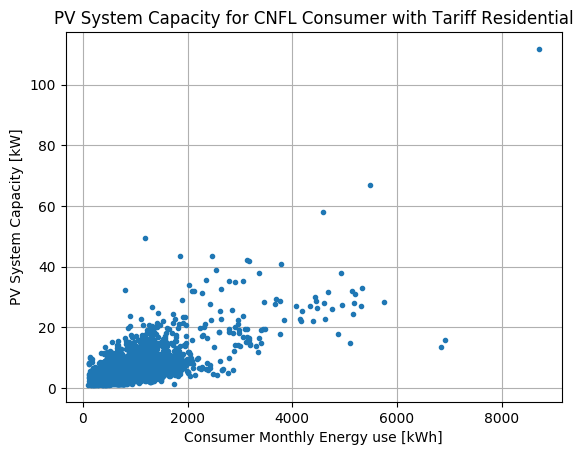

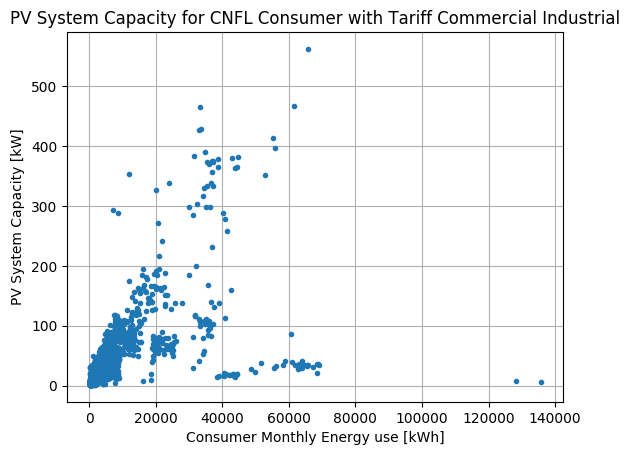

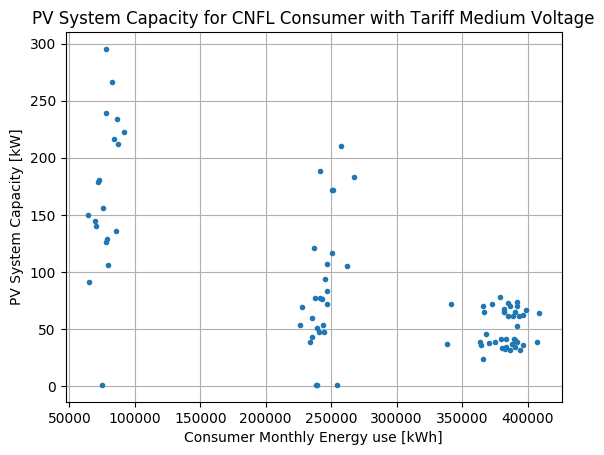

In [5]:
plot_all_tariffs_per_company(all_cnfl, "CNFL")

## Comparing this real-world data with the predicted adoption of the economically rational model in Notebook 4

Now we have obtained the Base_GD data, and used it to infer the real-world installation of PV system capacity in Costa Rica. Recall that the purpose of this data is to serve as a comparison point for our analytical estimates of the ideal PV system capacity that consumers should install. These analytical values are calculated for different rate groups and consumption levels. The three main categories are Residential (Households), Commerical-Industrial (Small and Medium business and industry), and Medium Voltage (the counterintuitive name for the class of largest electricity users). For each of these categories, we can plot our analytical values alongside the inferred real-world installation, to see how they compare.

### Residential consumers

We begin with the consumers in the Residential rate group. This code enumerates through a variety of consumption levels, stepping through at different granularities to provide a detailed picture without incurring unnecessary computational expense. At each consumption level, we call upon a function which, in turn, determines the PV capacity which will maximize the Net Present Value of all cashflows associated with installation, operation and maintenance of the PV system. This function tailors its results according to the specific tariffs applied to a given rate group.

In [6]:
# Residential
consumption_1 = 100:100:1500
res_model_predictions = []
for (ix, co) in enumerate(consumption_1)
    cnfl_residential.econsumption = co; get_pmax(cnfl_residential);
    res = optimal_pv(cnfl_residential, PVRes, 0.0:0.5:15, BAC1, tariff_increase = true)
    push!(res_model_predictions, res[1][2])
end

consumption_2 = 2000:500:4000
for (ix, co) in enumerate(consumption_2)
    cnfl_residential.econsumption = co; get_pmax(cnfl_residential);
    res = optimal_pv(cnfl_residential, PVRes, 0.0:0.5:15, BAC1, tariff_increase = true)
    push!(res_model_predictions, res[1][2])
end

res_consumption = vcat(consumption_1, consumption_2)

20-element Array{Int64,1}:
  100
  200
  300
  400
  500
  600
  700
  800
  900
 1000
 1100
 1200
 1300
 1400
 1500
 2000
 2500
 3000
 3500
 4000

Now we plot this estimate of ideal PV installation, alongside what we know to be the real-world installation of PV systems for customers at various electricity consumption levels.

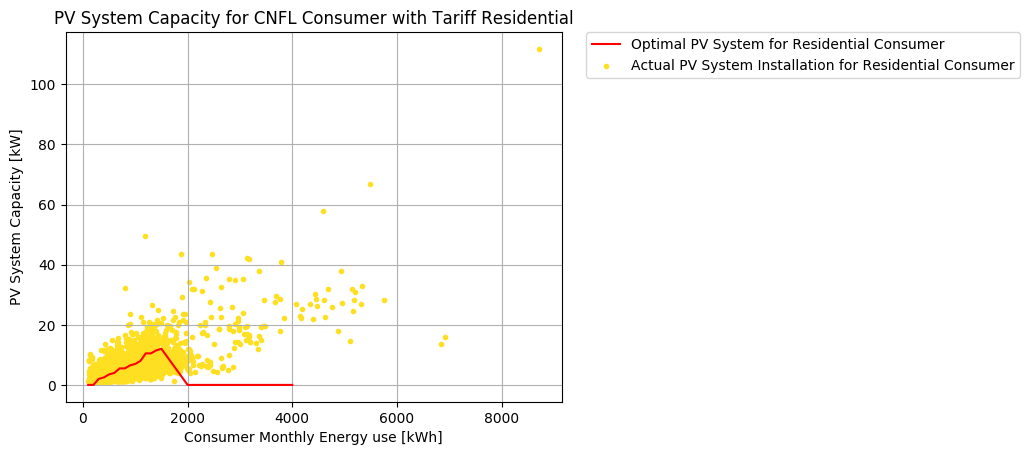

PyObject Text(0.5, 1, 'PV System Capacity for CNFL Consumer with Tariff Residential')

In [7]:
plot_single_tariff_category_per_company_with_model_prediction(all_cnfl, "Residential", "CNFL", res_consumption, res_model_predictions)

### Commerical Industrial

We continue with a similar analysis for the consumers in the Commerical-Industrial rate group.

In [8]:
# Commerical Industrial
consumption1 = 100:100:1000
comind_model_predictions = []
for (ix, co) in enumerate(consumption1)
    cnfl_commercial.econsumption = co; get_pmax(cnfl_commercial);
    res = optimal_pv(cnfl_commercial, PVRes, 0.0:10:100, BAC1, tariff_increase = true)
    push!(comind_model_predictions, res[1][2])
end

consumption2 = 2000:1000:10000
for (ix, co) in enumerate(consumption2)
    cnfl_commercial.econsumption = co; get_pmax(cnfl_commercial);
    res = optimal_pv(cnfl_commercial, PVRes, 0.0:10:200, BAC1, tariff_increase = true)
    push!(comind_model_predictions, res[1][2])
end

consumption3 = 20000:10000:60000
for (ix, co) in enumerate(consumption3)
    cnfl_industrial.econsumption = co; get_pmax(cnfl_industrial);
    res = optimal_pv(cnfl_industrial, PVRes, 0.0:20:300, BAC1, tariff_increase = true)
    push!(comind_model_predictions, res[1][2])
end

comind_consumption = vcat(consumption1, consumption2, consumption3);

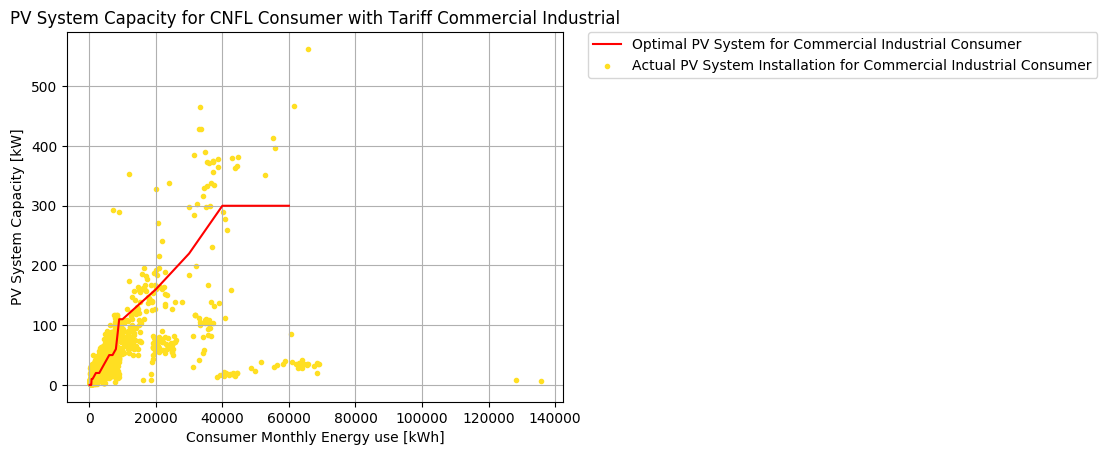

PyObject Text(0.5, 1, 'PV System Capacity for CNFL Consumer with Tariff Commercial Industrial')

In [9]:
plot_single_tariff_category_per_company_with_model_prediction(all_cnfl, "Commercial Industrial", "CNFL", comind_consumption, comind_model_predictions)

### Medium Voltage

And finally, a parallel analysis for the Medium Voltage customers.

In [10]:
# Medium Voltage
consumption1 = 500:500:10000
tmt_model_predictions = []
for (ix, co) in enumerate(consumption1)
    cnfl_mediumvoltage.econsumption = co; get_pmax(cnfl_mediumvoltage);
    res = optimal_pv(cnfl_mediumvoltage, PVRes, 0.0:50:200, BAC1, tariff_increase = true)
    push!(tmt_model_predictions, res[1][2])
end

consumption2 = 10000:1000:200000
for (ix, co) in enumerate(consumption2)
    cnfl_mediumvoltage.econsumption = co; get_pmax(cnfl_mediumvoltage);
    res = optimal_pv(cnfl_mediumvoltage, PVRes, 0.0:50:200, BAC1, tariff_increase = true)
    push!(tmt_model_predictions, res[1][2])
end

consumption3 = 200000:100000:600000
for (ix, co) in enumerate(consumption3)
    cnfl_mediumvoltage.econsumption = co; get_pmax(cnfl_mediumvoltage);
    res = optimal_pv(cnfl_mediumvoltage, PVRes, 0.0:50:200, BAC1, tariff_increase = true)
    push!(tmt_model_predictions, res[1][2])
end

tmt_consumption = vcat(consumption1, consumption2, consumption3);

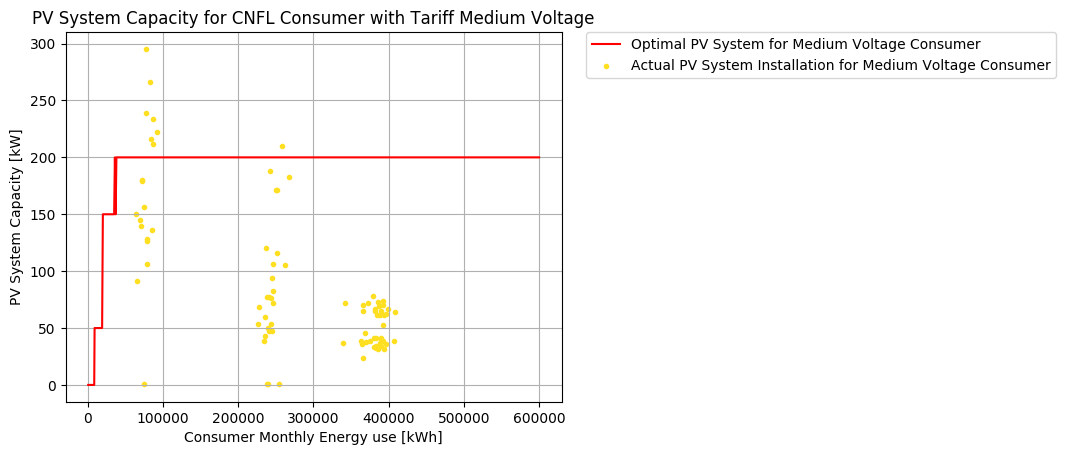

PyObject Text(0.5, 1, 'PV System Capacity for CNFL Consumer with Tariff Medium Voltage')

In [11]:
plot_single_tariff_category_per_company_with_model_prediction(all_cnfl, "Medium Voltage", "CNFL", tmt_consumption, tmt_model_predictions)

## Running piecewise regressions on different tariff categories

Now that we have this information in graphical format, it is time for us to more closely examine how the two data sets line up. Is it the case that the analytical estimates of ideal PV installation lines up well with the real-world data? Are there interesting patterns, or inflection points, which may highlight underlying issues with the model? In order to investigate these questions, we can begin with running simple linear regressions on the real-world installation data. This allows us to make a more direct comparison between the distribution of data, and the single-line analytical estimate.

We will begin with the residential data. Looking at the analytical model, it is clear that there is a disjoint estimate. For all consumption under a certain value, it appears to have a somewhat linear relationship with ideal installation. But after that cutoff, it falls to zero and remains there. However, the real-world installation diverges from that and continues to increase. With that in mind, we wanted to see whether the model accurately tracks real-world installation at least under that turning point. We test this by running a piecewise linear regression, partitioned at a point deemed to be close to where the model abruptly turns.

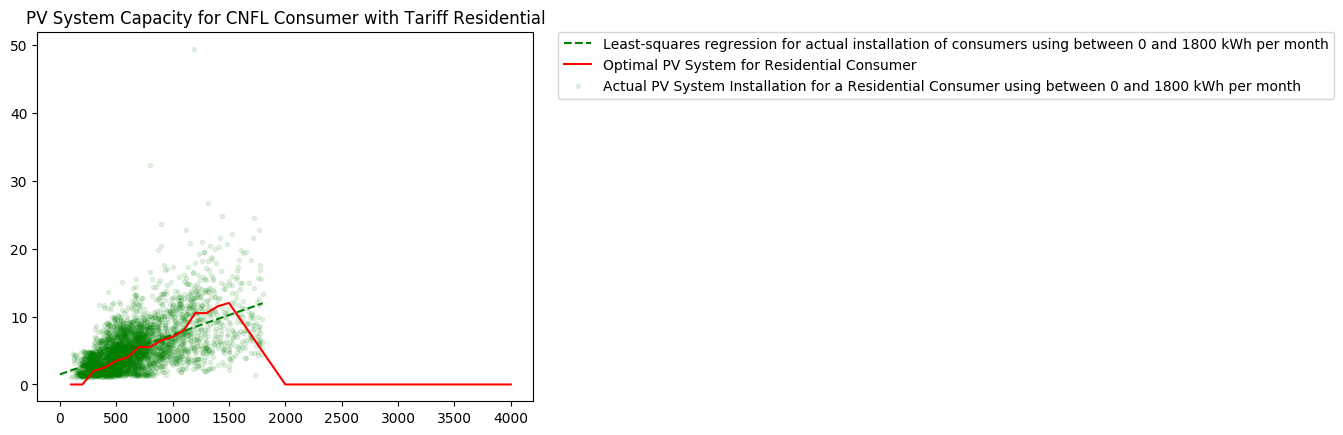

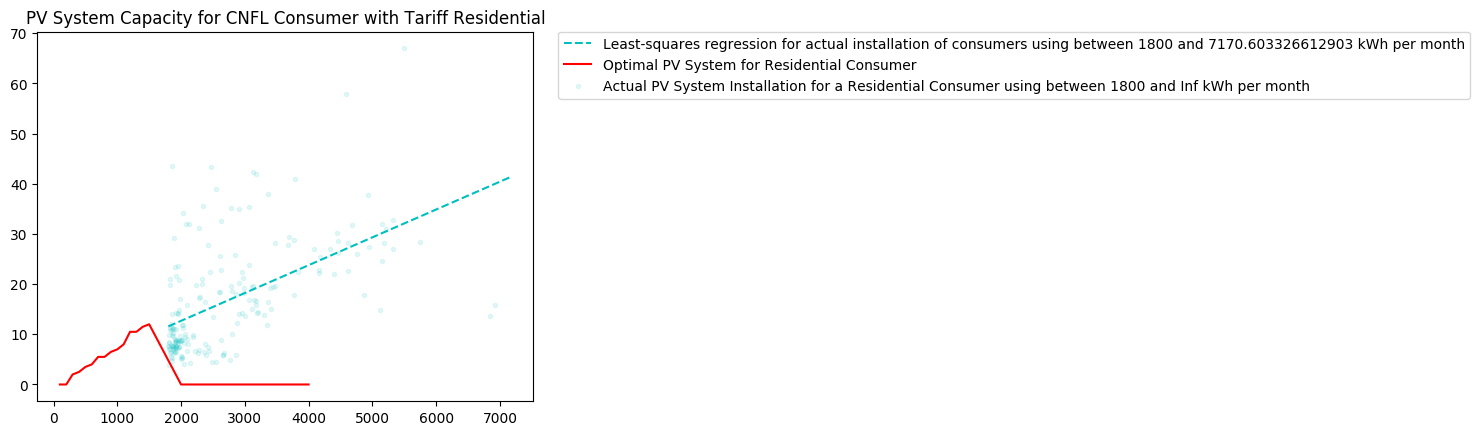

In [13]:
plot_tariff_category_with_many_regressions(all_cnfl, "Residential", "CNFL", res_consumption, res_model_predictions, [1800])

This definitely seems to be the case. Below the cutoff point, we see the model tracking very closely to the linear regression of the dataset. After the cutoff, the trend of the data actually continues quite similarly. This could suggest that the model's assumptions are accounting for some factor (or failing to), which does not match with reality, and results in estimates of installation crashing down to zero. It could also be that the consumers in this upper region don't "belong" in the residential category. We stress that the data itself doesn't immediately offer solutions, but instead highlights and pinpoints the potential issues in the analytical model.

We can follow a similar strategy for the commerical industrial rate group, running a piecewise regression of the data before and after a discernible turning point.

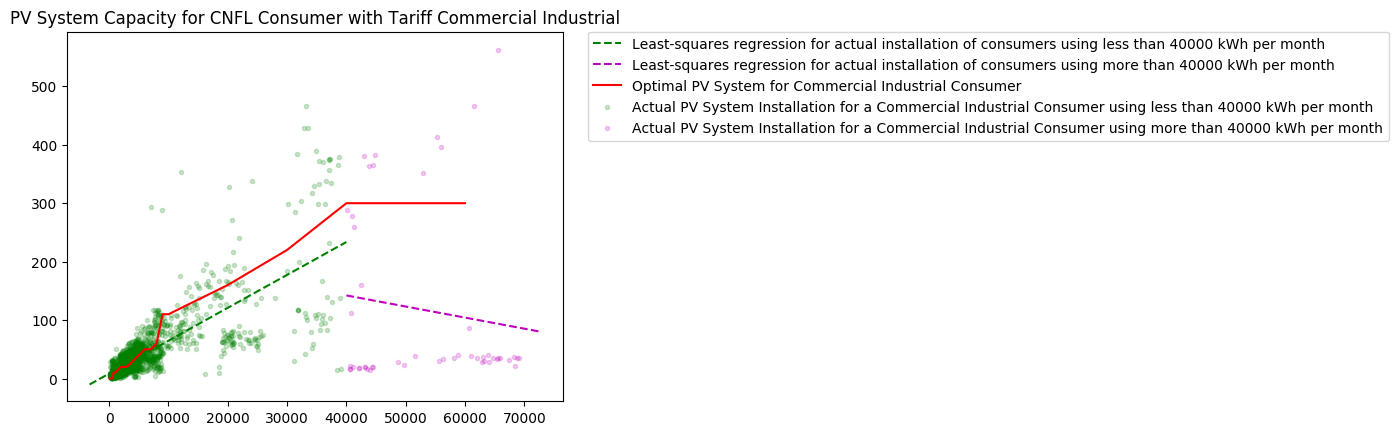

PyObject <matplotlib.legend.Legend object at 0x14200c780>

In [15]:
plot_tariff_category_with_two_regressions(all_cnfl, "Commercial Industrial", "CNFL", comind_consumption, comind_model_predictions, 40000)

The commercial industrial results are quite interesting. While the under-cutoff model slightly underestimates installation, we see that the over-cutoff model remains flat where the trend of the data is a definite downward at a much lower overall level. One possible explanation for this trend, could have to do with the upfront costs of the largest viable PV installations for these Commerical Industrial consumers. If they are sufficiently expensive, and the consumers are using high enough levels of electricity, then any per-unit savings are eclipsed by both the upfront cost as well as the sheer volume of (albeit discounted) per-unit costs.

Another possible explanation is a similar "mis-categorization" to what was theorized earlier. If the largest Commercial-Industrial consumers qualify for lower rates from the utility company themselves, then there is significantly less incentive for installing PV systems and cutting per-usage costs in that manner.

We chose not to run this analysis on the Medium Voltage category, since a visual inspection of the real-world installation data told us that any linear regression would be quite nonsensical and unable to represent the data distribution.

## Including 1 SD error bars in the linear regressions of the data

Although we conducted our previous analysis using the linear regression of the datasets, we want to get an understanding of how likely it is that those regression lines are at their locations due to true trends in the data, as opposed to chance. One way of assessing that is by also displaying error bars around the regression line. These next graphs, when calculating the linear regression of the datasets, also obtains the standard deviation of the data. Using that value, we can draw lines which outline the range that demarks one standard deviation from the linear regression. This can be used as a proxy for the reasonable trend of the data. A wide range means that there is less certainty in the position of the regression line. This can be demonstrated in the graph of the Medium Voltage data, included solely for illustrative purposes.

Here we demonstrate this with the residential data. Note that the following graphs also further split each rate group into subtariffs, which is a system used for understanding the various distinct groups that may be nevertheless paying the same rates to the electric company. In the residential case, there is only one subtariff group, so it makes no difference, and it seems to be quite a narrow error margin.

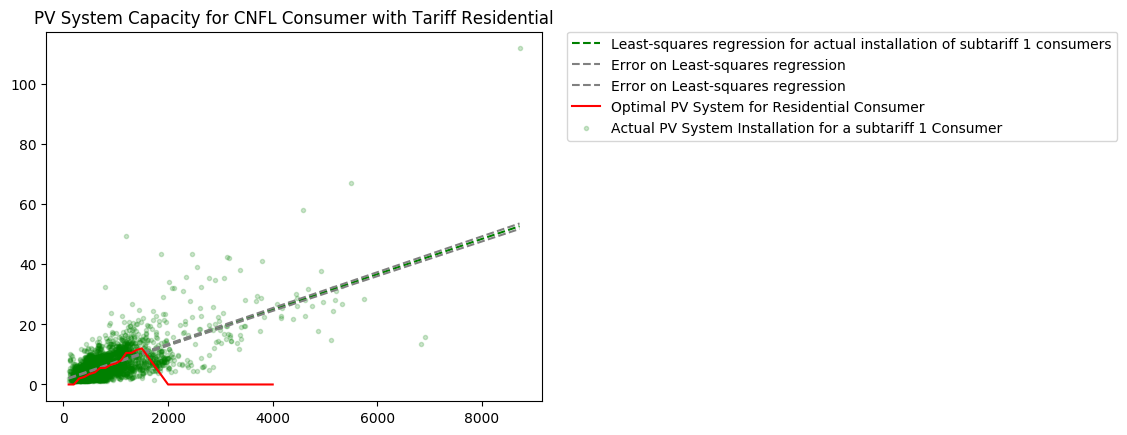

In [17]:
plot_with_subtariff_wise_regression(all_cnfl, "Residential", "CNFL", res_consumption, res_model_predictions)

However, when we graph the Commerical Industrial data, we see that there are several subgroups. And in fact, different subgroups may over- or under-shoot the analytical model in the first part. Only two subgroups have values beyond the cutoff monthly consumption amount, one of which consistently overshoots the model. The latter subgroup is spread both above and below the analytical model, for consumption values beyond the cutoff point.

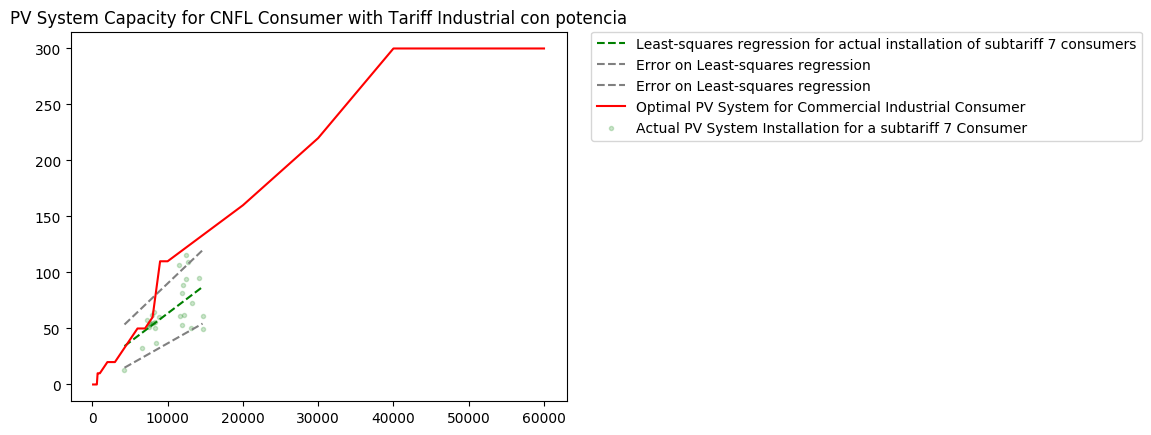

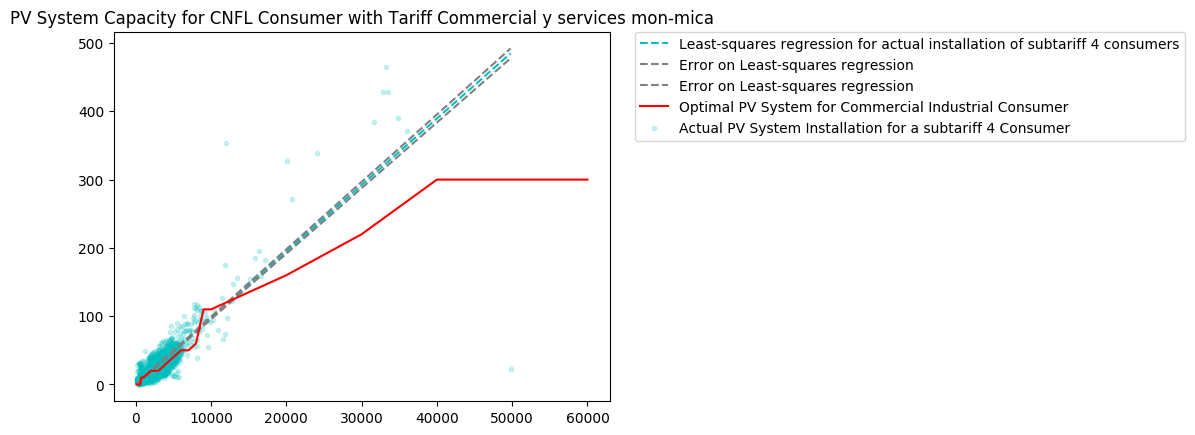

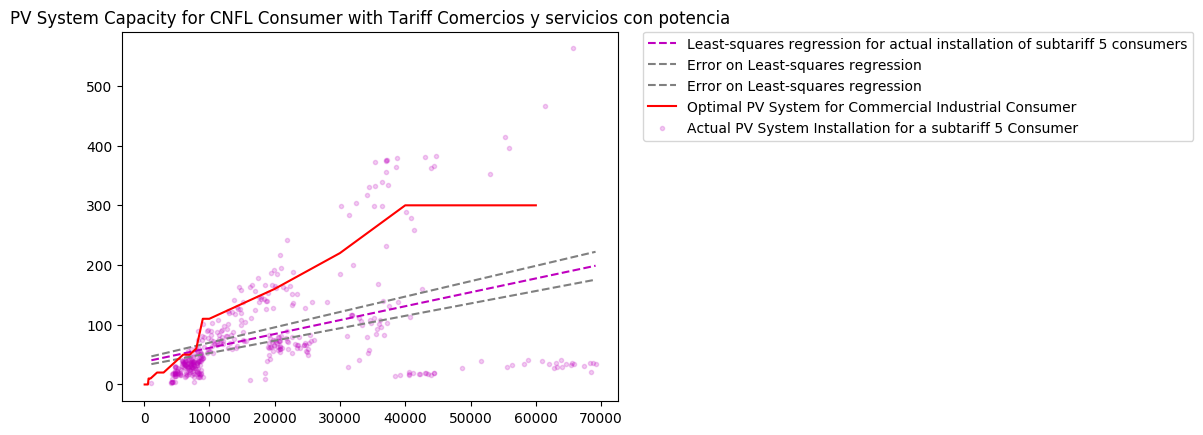

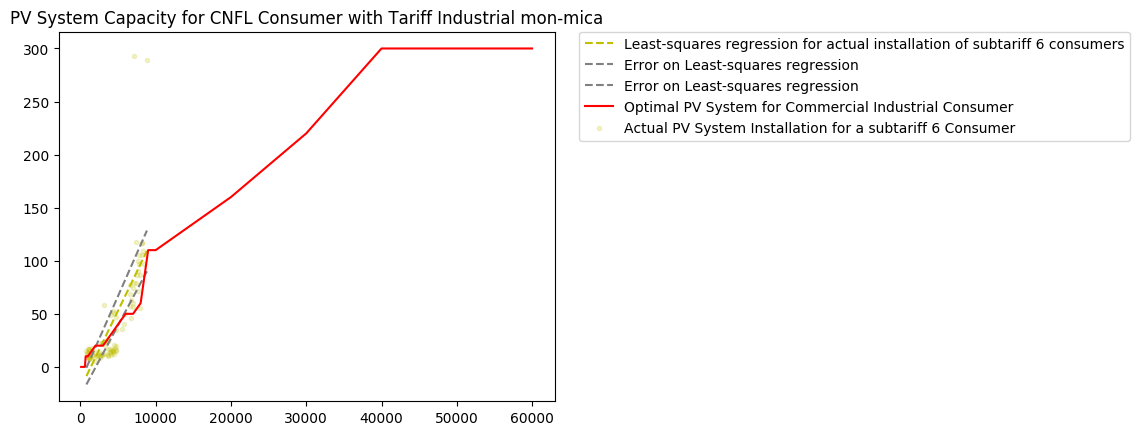

In [18]:
plot_with_subtariff_wise_regression(all_cnfl, "Commercial Industrial", "CNFL", comind_consumption, comind_model_predictions)

Once again, the data for the Medium Voltage rate group is quite difficult to interpret, and is mostly included to illustrate the large error range of the regression line.

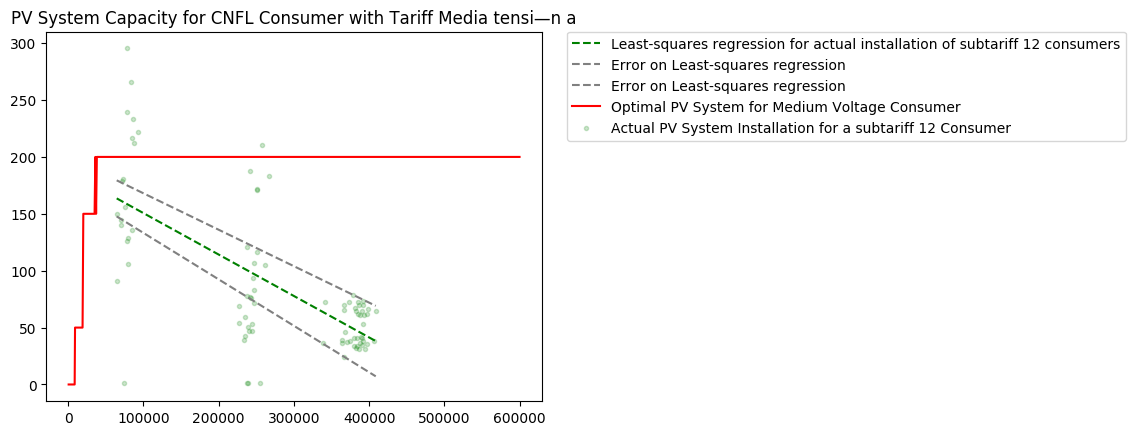

In [19]:
plot_with_subtariff_wise_regression(all_cnfl, "Medium Voltage", "CNFL", tmt_consumption, tmt_model_predictions)